# Practical 7: Feedforward Neural Networks

The aim of the praticalis to build feedforward neural networks to classify fetal health in order to prevent child and maternal mortality.

We will used a dataset of fetal cardiotocograph (CTG) data from 2126 pregnant women. These data are avialiable __[here](https://archive.ics.uci.edu/ml/datasets/cardiotocography)__ through the University of California Irvine Machine Learning Repository. A copy of the data is also in Keats. Please download it before the lab and place it in the same folder you are running this program from.

Each data entry consists of 21 attributes used in the measurements of fetal heart rate (FHR) and uterine contractions (UCs) on CTG data. The CTG of pregnant women were classified by three experts who were specialized in obstetrics; roughly 70% of the data samples are normal, 20% are suspect, and 10% have a pathological fetal state.

The features in the database are:
1. Fetal heart rate baseline (beats per minute)
2. Number of accelerations per second
3. Number of fetal movements per second
4. Number of uterine contractions per second
5. Number of light decelerations per second
6. Number of severe decelerations per second
7. Number of prolonged decelerations per second
8. Percentage of time with abnormal short-term variability
9. Mean value of short-term variability
10. Percentage of time with abnormal long-term variability
11. Mean value of long-term variability
12. Width of FHR histogram
13. Minimum of FHR histogram
14. Maximum of FHR histogram
15. Number of histogram peaks
16. Number of histogram zeroes
17. Histogram mode
18. Histogram median
19. Histogram variance
20. Histogram tendency
21. Fetal state class code (1=Normal, 2=Suspected, 3=Pathological)

<hr style="border:1px solid black"> </hr>

## Step 1 Set-up
Import all toolboxes need to support the tutorial

### Tensorflow
We will use the __[Keras](https://keras.io)__, library in __[TensorFlow](https://www.tensorflow.org)__, to build and test feedforward neural networks.

Remember to install TensorFlow *before* starting the tutorial. Instructions can be found in the Day 7 section of the course Keats page. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, confusion_matrix

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

2022-05-17 15:10:16.908529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/changhyun/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-05-17 15:10:16.908555: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


**Observing Model training** the following function will be used to obsevere the behaviour of the models after they have been trained. It plots the loss and accuracy of model after every training epoch

In [2]:
def plot_learningCurve(history, epoch):
  # Plot training & validation accuracy values
  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

<hr style="border:1px solid black"> </hr>

## Step 2 Load Data

Load the data using Pandas

In [3]:
data = pd.read_csv("fetal_health.csv")

As in many many helath tasks, the class distributions are unbalanced. This can be seen via plotting a histogram

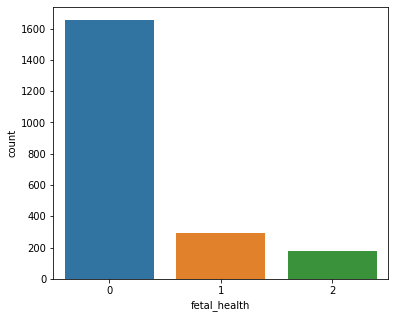

In [6]:
plt.figure(figsize=(6,5))
ax = sns.countplot(x = data['fetal_health'])

<hr style="border:1px solid black"> </hr>

## Step 3 Preprocessing

We now need to organise the data so that it is in a form expected by keras/TensorFlow, and to enable us to do robust machine learning

The first step is to change the range of the labels from 1-3 to 0-2, this is needed in a later step to help us encode the label data into a matrix which has binary values. 

**Question** Why do we need to do this?

In [5]:
label = LabelEncoder()
label.fit(data['fetal_health'])
data['fetal_health'] = label.transform(data['fetal_health'])

The next step is to organise the data into our training, validation and test partitions. 

**Question** Why do we need *three* splits? cross validation

In [7]:
X = data.drop(columns='fetal_health')
y = data['fetal_health']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42, stratify = y_train)

n_features = len(X_train.columns)
n_features

21

When working with unbalnaced data, it can be useful to peform weight balancing. This is a technique in which we muliple the output the loss function output by a factor proportional to the *importance* of each sample to the model. 

We will perform this in our model, but assigning weights proportional to the amount of data in the model. We need to store these weights in a dictionary for inlcusion into our model at a later step. 

In [13]:
# Calculate class weights from sklearn
class_weight_array = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
print('\nClass weights: {}'.format(class_weight_array)) 

# Class weights as dictionary for Keras
keys = [0,1,2] 
class_weight_dict = dict(zip(keys, class_weight_array.T))
print('\nClass weights dict: {}'.format(class_weight_dict))


Class weights: [0.42848141 2.39858907 4.01179941]

Class weights dict: {0: 0.428481411468179, 1: 2.398589065255732, 2: 4.011799410029498}


The next step is to convert the data into Numpy arrays 

In [14]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

Next we convert the label data into a binary score matrix representation

**Question** What does this step do to the representation of the labels?

In [15]:
y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)
y_test = to_categorical(y_test, 3)

y_train[0]

array([1., 0., 0.], dtype=float32)

Finally, we standardise the data. 

**Question** Why is this step necessary?

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

<hr style="border:1px solid black"> </hr>

##  Step 4 Building a feedforward Neural Network

We will build a simple single layer feedforward network via a keras __[sequential](https://keras.io/guides/sequential_model/)__ model. This model allows us to delcare an ordered stack of layers in sequential order, each layer has only one input and one output.

**Question:** How many units in the hidden layer? What is the activation function?

**Question:** What is the activation function of the output layer, why is this function used? 

In [75]:
# define the keras model
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, activation='tanh'))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(16, activation='tanh'))
    model.add(Dense(3, activation='softmax'))
    return model

Compile the model then build it to start training 

**Question:** What are the optimiser and loss function being used? Are there a better alternatives?

**Question:** What is the role of the EPOCH and BATCH_SIZE variables? 

**Question:** How does the loss values on the training and validation data change over the epochs? 

2022-05-17 15:18:08.321346: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/changhyun/catkin_ws/devel/lib:/opt/ros/noetic/lib
2022-05-17 15:18:08.321374: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-17 15:18:08.321398: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (changhyun-X510UAR): /proc/driver/nvidia/version does not exist
2022-05-17 15:18:08.321699: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


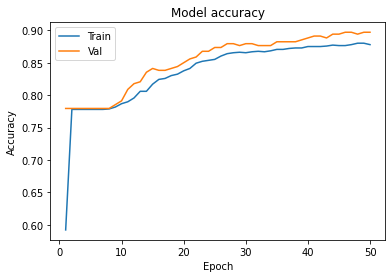

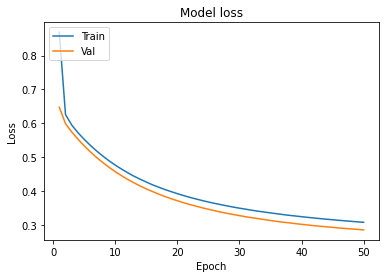

In [18]:
model = create_model()

model.compile(optimizer='SGD', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50
BATCH_SIZE = 25

history = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    validation_data=(X_val, y_val),
    verbose=0
)

plot_learningCurve(history, EPOCHS)

Observe the models performance on the test set? Does this seem reasonable for this experiement? 

In [20]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
14/14 [==============================] - 0s 1ms/step - loss: 0.3389 - accuracy: 0.8803
test loss, test acc: [0.3389364182949066, 0.8802816867828369]


As the class data is not balanced, it is worth checking the *unweighted average recall* (UAR) and confusion matrix.
- Are these what you expected given the accuracy?
- What can you observe about the performance of the model from the confusion matrix?

14/14 [==============================] - 0s 1ms/step
Unweighted Recall of the model is : 0.6692


<AxesSubplot:>

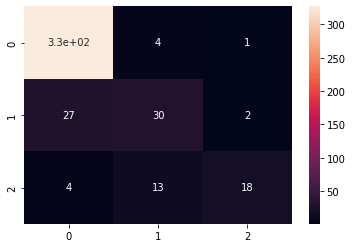

In [21]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_vec = np.argmax(y_test, axis=1)

UAR = recall_score(y_test_vec, y_pred , average="macro")

print( "Unweighted Recall of the model is : " + str(round(UAR, 4)))

cf_matrix = confusion_matrix(y_test_vec, y_pred)
sns.heatmap(cf_matrix, annot=True)

<hr style="border:1px solid black"> </hr>

##  Step 5 Inclusion of class weights into model

Now re-run the model, however now including the class weights we calculated earlier. 
- How does this addition effect the performance of the model in terms of accuracy and UAR
- Can you observe these changes in the confusion matrix?

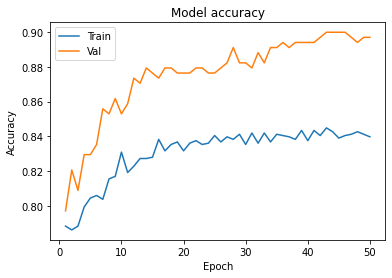

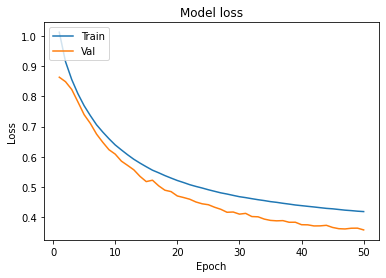

In [22]:
model = create_model()

model.compile(optimizer='SGD', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50
BATCH_SIZE = 25

history = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val),
    verbose=0
)

plot_learningCurve(history, EPOCHS)

In [23]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
14/14 [==============================] - 0s 1ms/step - loss: 0.4296 - accuracy: 0.8427
test loss, test acc: [0.42958691716194153, 0.84272301197052]


In [24]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_vec = np.argmax(y_test, axis=1)

UAR = recall_score(y_test_vec, y_pred , average="macro")

print( "Unweighted Recall of the model is : " + str(round(UAR, 4)))

14/14 [==============================] - 0s 1ms/step
Unweighted Recall of the model is : 0.8189


<AxesSubplot:>

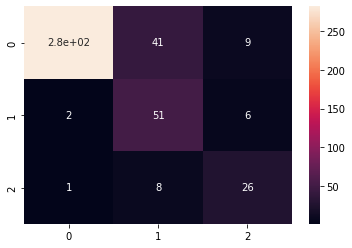

In [25]:
cf_matrix = confusion_matrix(y_test_vec, y_pred)
sns.heatmap(cf_matrix, annot=True)

<hr style="border:1px solid black"> </hr>

## Exercises

Using the class-weighted example, Explore the effect on unweighted recalll of changing different model hyperparameters. 

Suggestions include:
- Adding a new layer into the model
- Changing the width of the layers
- Changing the activation functions, not of the final layer (why?)
- Changing the optimizer, does this also effect model training time? 

<hr style="border:1px solid black"> </hr>

In [118]:
def create_model():
    model = Sequential()
    model.add(Dense(64, input_dim=n_features, activation='relu'))    
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

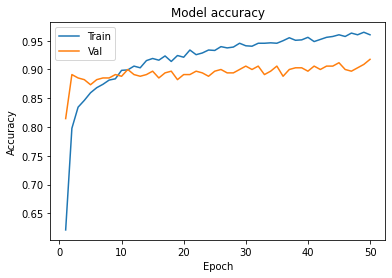

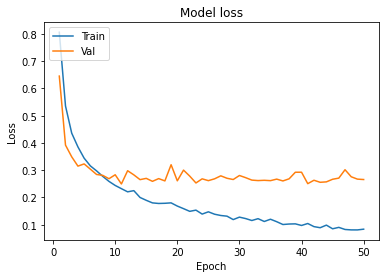

In [131]:
model = create_model()

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 50
BATCH_SIZE = 20

history = model.fit(
    X_train, y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS,
    class_weight=class_weight_dict,
    validation_data=(X_val, y_val),
    verbose=0
)

plot_learningCurve(history, EPOCHS)

In [126]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Evaluate on test data
14/14 [==============================] - 0s 1ms/step - loss: 0.4207 - accuracy: 0.8850
test loss, test acc: [0.4206768572330475, 0.8849765062332153]


14/14 [==============================] - 0s 1ms/step
Unweighted Recall of the model is : 0.8354


<AxesSubplot:>

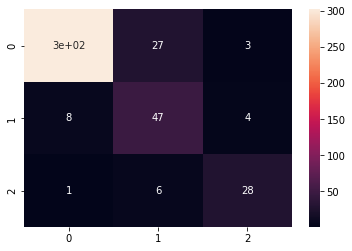

In [127]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_vec = np.argmax(y_test, axis=1)

UAR = recall_score(y_test_vec, y_pred , average="macro")

print( "Unweighted Recall of the model is : " + str(round(UAR, 4)))

cf_matrix = confusion_matrix(y_test_vec, y_pred)
sns.heatmap(cf_matrix, annot=True)